# Introduction

When it comes to the domain of Natural Language Processing, there are many available pre-trained models that could be useful in fine-tuning in order to get the model more specialized within out use case. Therefore, in this project we are going to:

1. Fine-Tune multiple revisions of BERT (BERT, RoBERTa, DistilBERT) on the **go_emotions** dataset to check which model had performed well.
2. Derive true labels *fixed* on the labels of the **go_emotions** dataset to act as a true label through XLNet with MultipleChoice.
3. Evaluate on how the more sentiment-generalized BERT models could perform accross different use cases ranging from (Finance to Mental Health to NEWS).

The overall flow of the project is shown in <u>Figure 1</u>:

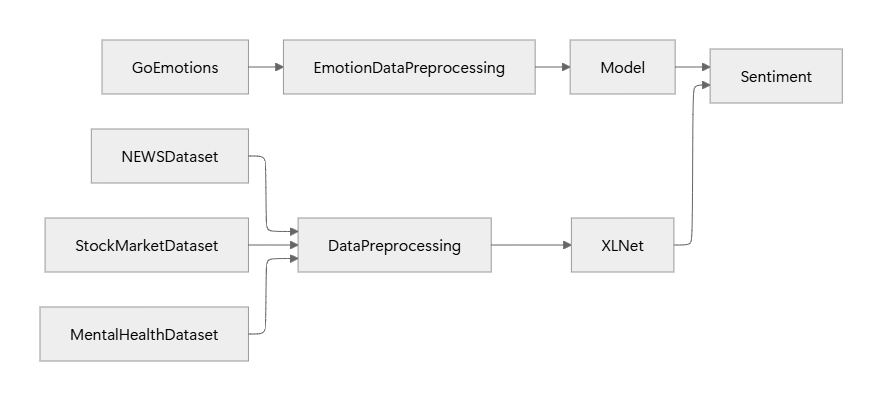

Figure 1


## Analysis on the Training-Set (GoEmotions Dataset by Google)
There are 3 main reasons why we conduct Data Processing:
 (a) Remove symbols and irrelevant content
 (b) Normalise texts to reduce vocabulary size
 (c) Improve tokenisation
In this notebook, GoEmotions Dataset by Google in Kaggle is used. Data cleaning techniques such as RegEx, and stopword removal are used to clean the dataset, before doing tokenization. After that, stemming/lemmatization can be selected as options to reduce vocab size for easier processing. Parts of Speech tagging is used to label the tokens. TF-IDF, NMF and BM25 are then used as part of analysis of the processed dataset.
Before feeding any data into the models, we must analyze the strengths and weaknesses in the data that is being handled. Data in unprocessed datasets can raw and noisy, therefore usually requiring some cleaning and optimization for tokenizers to work. For this project, the data is fed into BERT, RoBERTA, DistilBERT and XLNET, robust transformer-based models whose respective tokenizers prefer raw, unprocessed sentences. These models learn context through stopwords, slang, special characters and punctuation so their removal would reduce accuracy. The objective of our preprocessing is to analyse characteristics in our data, and to demonstrate what we have learned in class

## Regex Cleaning & Tokenisation
For TF-IDF and BM25 to run efficiently, we need to preprocess the data before tokenisation. We firstly set all words to lowercase, then remove URLs and "@mentions" that tweets sometimes use. We remove "#" from "#hashtags" but keep the content in the hashtag. Next, all the non-alphabetic characters are removed, such as punctuation, digits, emojis and symbols. Repeated whitespaces are normalised to a single space.
Afterwords, tokenisation is done to convert sentences into "tokens" that the machines can understand. Machines cannot understand raw text. It also creates sentence strcuture and sometimes gives each token a "token ID" so models can identify them.
## Stopword Removal
Next, stopwords are removed. Examples include "a, an, the, my, your, i, you, he". These words are useful in helping transformers predict context but are not helpful for term-frequency or bag-of-words based analysis. At this stage you can add in custom stopwords specific to your task. For example a music dataset might add "chorus, verse, repeat, na, la" as stopwords to prevent them topping TF-IDF scores. Our code adds a line removing all words shorter than three letters for efficiency, as they often will not carry meaning.

## Stemming and Lemmatization
Stemming reduces words to their root stem, for example, "study' becomes "studi" and "better" stays as "better". The stemmed words do not have to be proper english words. Lemmatization on the other hand reduces words to their "lemma", or dictionary base form, which has to be proper vocabulary. "study" becomes "study" while "better" becomes "good".
These 2 techniques are done to reduce vocabulary size and also improve generalization, as the model will be able to recognize more word's similar base forms rather than 3 to 4 different words. This increases the future model's training speed and accuracy as it creates a smaller vocabulary that can account for a large range of words.
## Part-of-speech Tagging (POS-Tagging)
POS tagging is the labelling of each word with reference to its corresponding part of speech (eg. noun, verb, adjective). Its main purpose is to allow models to understand sentence structure and meaning. Lemmatization works much more efficiently with POS tagging as it needs to know if the word is a verb, noun or adjective to produce the correct base form.
## Term Frequency-Inverse Document Frequency (TF-IDF)
TF-IDF score is an indicator to show how important a word is in its document relative to the corpus. Term Frequency counts the number of occurrences of a word in a document, while Inverse Document Frequency penalises words commonly found across many documents. High frequency in a document but low frequency in a corpus means high importance as only that document contains that theme. High frequency in both a document and corpus means lower importance as many documents share the same theme.
## Non-Negative Matrix Factorisation (NMF)¶
The next step is Non-Negative Matrix Factorization (NMF). NMF is done to find latent topics within a document. We factorize a Term-Document matrix (from TDF-IDF) into a word-topic matrix and a topic-document matrix. These matrices are then used to infer the semantic relations between words within a sentence.
## Best Match 25 (BM25)
BM25 is a ranking algorithm used to measure the relevancy of a document to a given query. The algorithm is considered to be an improvement over TF-IDF as it takes into account document length and is accounts for term frequency saturation. Some limitations of BM25 are that BM25 does not take semantics into account as it only measures how often a term appears. BM25 may not perform as well for extremely short documents due to it heavily relying on document length and term frequency to calculate scores given to a document.

# Analysis on the Training-Set

# Machine Learning Approach

## BERT and its Variants

For this project, we will be training different variants of the BERT algorithm in order to compute the most optimal and efficient model that could be used to be evaluated against the XLNet Model. More specifically, we would be training the original BERT and 3 variants of:

1. BERT
2. RoBERTA
3. DistilBERT

We would then be comparing  the models, against each other to compare the performance, training stability and their effectiveness in determining the sentiment of the text.

<u>Figure 2</u> shows the progression of the loss over the epochs

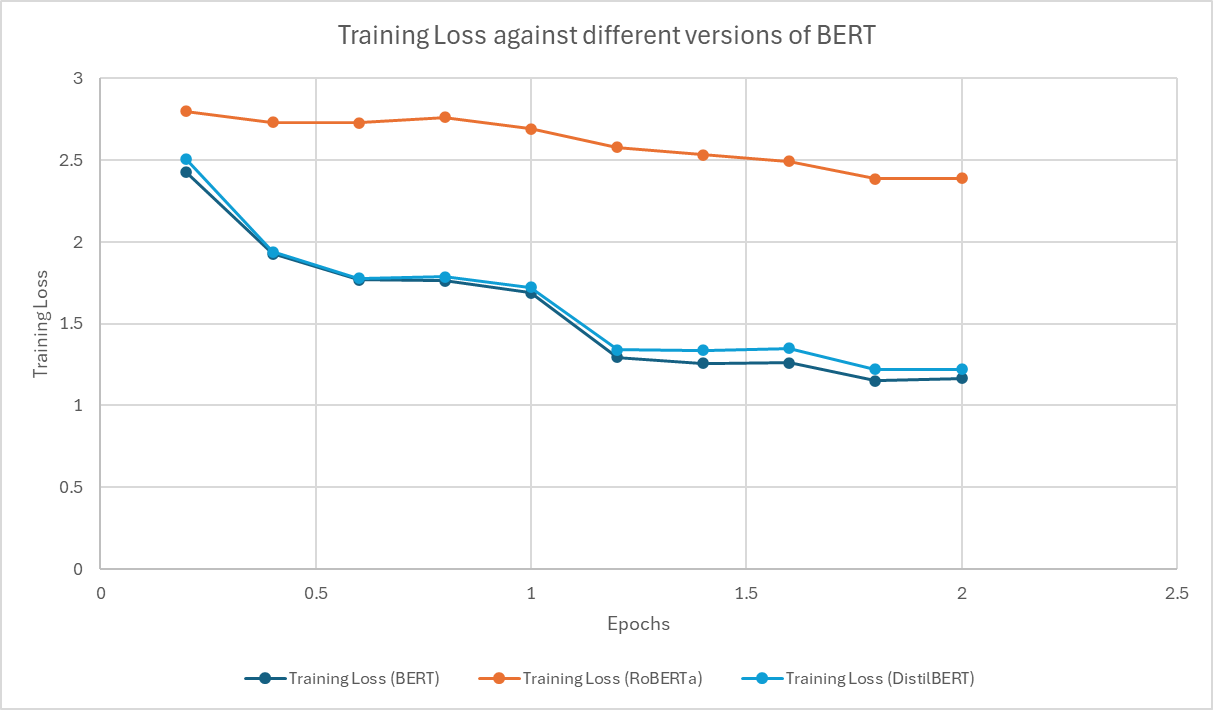

Figure 2

From the training-loss, it can be observed that RoBERTa had performed poorly compared to the other 2 variants with an average loss over the training epochs of **2.609**. The code below shows the training & testing algorithm used to train the BERT variants.


In [ ]:
# Importing the Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# Getting the Dataset
training_set = load_dataset('go_emotions')

num_training_samples = 10000

# Initializing the BERTS
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

# Initializing a list of Models
map_of_models = {"BERT": "bert-base-uncased",
                 "RoBERTa": "FacebookAI/roberta-base",
                 "DistilBERT": "distilbert-base-uncased"}

# Initializing the tokenizer
model_name = "RoBERTa" # Just input what model you want and the algorithm would automatically load all of the essential components
tokenizer = AutoTokenizer.from_pretrained(map_of_models[model_name])
model = AutoModelForSequenceClassification.from_pretrained(map_of_models[model_name], num_labels = 28)
cce = evaluate.load("accuracy")

# Loop to tokenize the data
def tokenize(dataset):
    return tokenizer(dataset['text'], padding='max_length', truncation=True)

# Processing the labels
def return_one_label(dataset):
    dataset['labels'] = dataset['labels'][0]
    return dataset # Only returning the first label of the traub

tokenized_dataset = training_set.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.map(return_one_label)


training_args = TrainingArguments(
    output_dir= f"{model_name}_trained_weights",
    per_device_train_batch_size = 4, 
    per_device_eval_batch_size = 4, 
    num_train_epochs = 2,
    push_to_hub = False
)

# Training the Model
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset= tokenized_dataset['train'].shuffle(seed=14).select(range(num_training_samples)),
    eval_dataset = tokenized_dataset['validation'].shuffle(seed=14).select(range(num_training_samples//2))
)

trainer.train()
print(trainer.evaluate())

In [ ]:
# Importing the Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer

# Initializing a list of Models
map_of_models = {"BERT": "bert-base-uncased",
                 "RoBERTa": "FacebookAI/roberta-base",
                 "DistilBERT": "distilbert-base-uncased"}

map_of_paths = {"BERT": "BERT_trained_weights\checkpoint-5000",
                "RoBERTa": "RoBERTa_trained_weights\checkpoint-5000",
                "DistilBERT": "DistilBERT_trained_weights\checkpoint-5000"}



# Initializing 

# Initializing the tokenizer
model_name = "BERT"

model = pipeline(task = 'sentiment-analysis', model=map_of_paths[model_name], tokenizer=AutoTokenizer.from_pretrained(map_of_models[model_name]))

print(model("WAKE UP! GEORGE SOROS “Drastically Ramps Up” Effort To Destroy America")) # Input the sentence to get the sentiment

### Evaluation

This section shows how our model had performed within a general framework:

Given 6 sentences (Sentence A to F), below is the table to show the sentences & their outcomes:

---

#### Sentences

Sentence A: I'm struggling to get a reason to keep going  It's just so hard. I've been trying to find a way to get better, but I just can't. (*Mental Health*)

Sentence B: Barclays share price subdued as bank faces fresh forex probe. (*Finance*)

Sentence C: COVER-UP: Both Obama and Clinton Lied About Trading Classified Emails. (*News*)

Sentence D: The buyer is real estate owner Propertos Oy , but the companies have agreed not to disclose financial details of the deal . (*Finance*)

Sentence E: Will you lose all your files? (*Mental Health*)

Sentence F: WAKE UP! GEORGE SOROS “Drastically Ramps Up” Effort To Destroy America. (*News*)

--- 

#### Outcomes

Sentence A:
* BERT: Disappointment
* RoBERTa: Neutral
* DistilBERT: Sadness
* **XLNet: Optimism**

Sentence B:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Realization**

Sentence C:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Optimism**

Sentence D:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Fear**

Sentence E:
* BERT: Curiosity
* RoBERTa: Neutral
* DistilBERT: Curiosity
* **XLNet: Fear**

Sentence F:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Greif**


## XLNet Analysis

The primary purpose of the XLNet was to standardize the labels from different datasets to test the performance of our fine-tuned BERT model on different situations, the implementation of the XLNet involves:

1. Implemented the sentiment classification workflow using a pretrained XLNet model and used it for a multiple choice prediction format.
2. Prepared the datasets by extracting sample sentences, applied prompt based encoding, and generated fixed sentiment labels (options) as the choices.
3. Applied softmax and argmax to determine the predicted sentiment label.
4. Ran the analysis across GoEmotions, Mental Health, Finance and News datasets.
5. This then shows XLNet's ability to capture sentiment cues and compares it's interpretability and behavior against the BERT variant models used in this project.
6. XLNet successfully generated sentiment predictions across mixed datasets.
7. The fixed sentiment label choices worked well.

# Streamlit interface

There are two tabs to the streamlit interface, the prediction tab and metrics tab with all the models. Figure 3 shows the prediction tab and figure 4 shows the metrics tab.

1. Each model is loaded from its checkpoint, and the tokenizer is loaded from the tokenizer.json (save_tokenizer,py), which is from AutoTokenizer from the transformers library.
2. A run_card.json is created with a utility function script (write_run_card.py), and for each card (one card per model), the run_id will be shown on the sidebar so users can select the model.
3. Users can choose which model to select, and type in a sentence within the textfield and click on the predict button to run predictions based on the chosen model. The probabilities for each class will additionally be calculated and represented in a bar chart below the final predicted emotion. This is amongst the 28 emotions listed.
4. We then ran inference on our UI for 5 randomly chosen lines in our demo, from a csv we compiled from the Fakenews, Finance and MentalHealth dataset which we included in our reference.
5. The metrics tab shows each model, where they all take in 28 classes, as well as their accuracy scores. Below, the training loss plot for all the models is shown.

Prediction tab:

Prediction tab with side bar for model selection through a dropdown, main page shows the prediction and chart. The text in the input field is a randomly input text for demonstration.

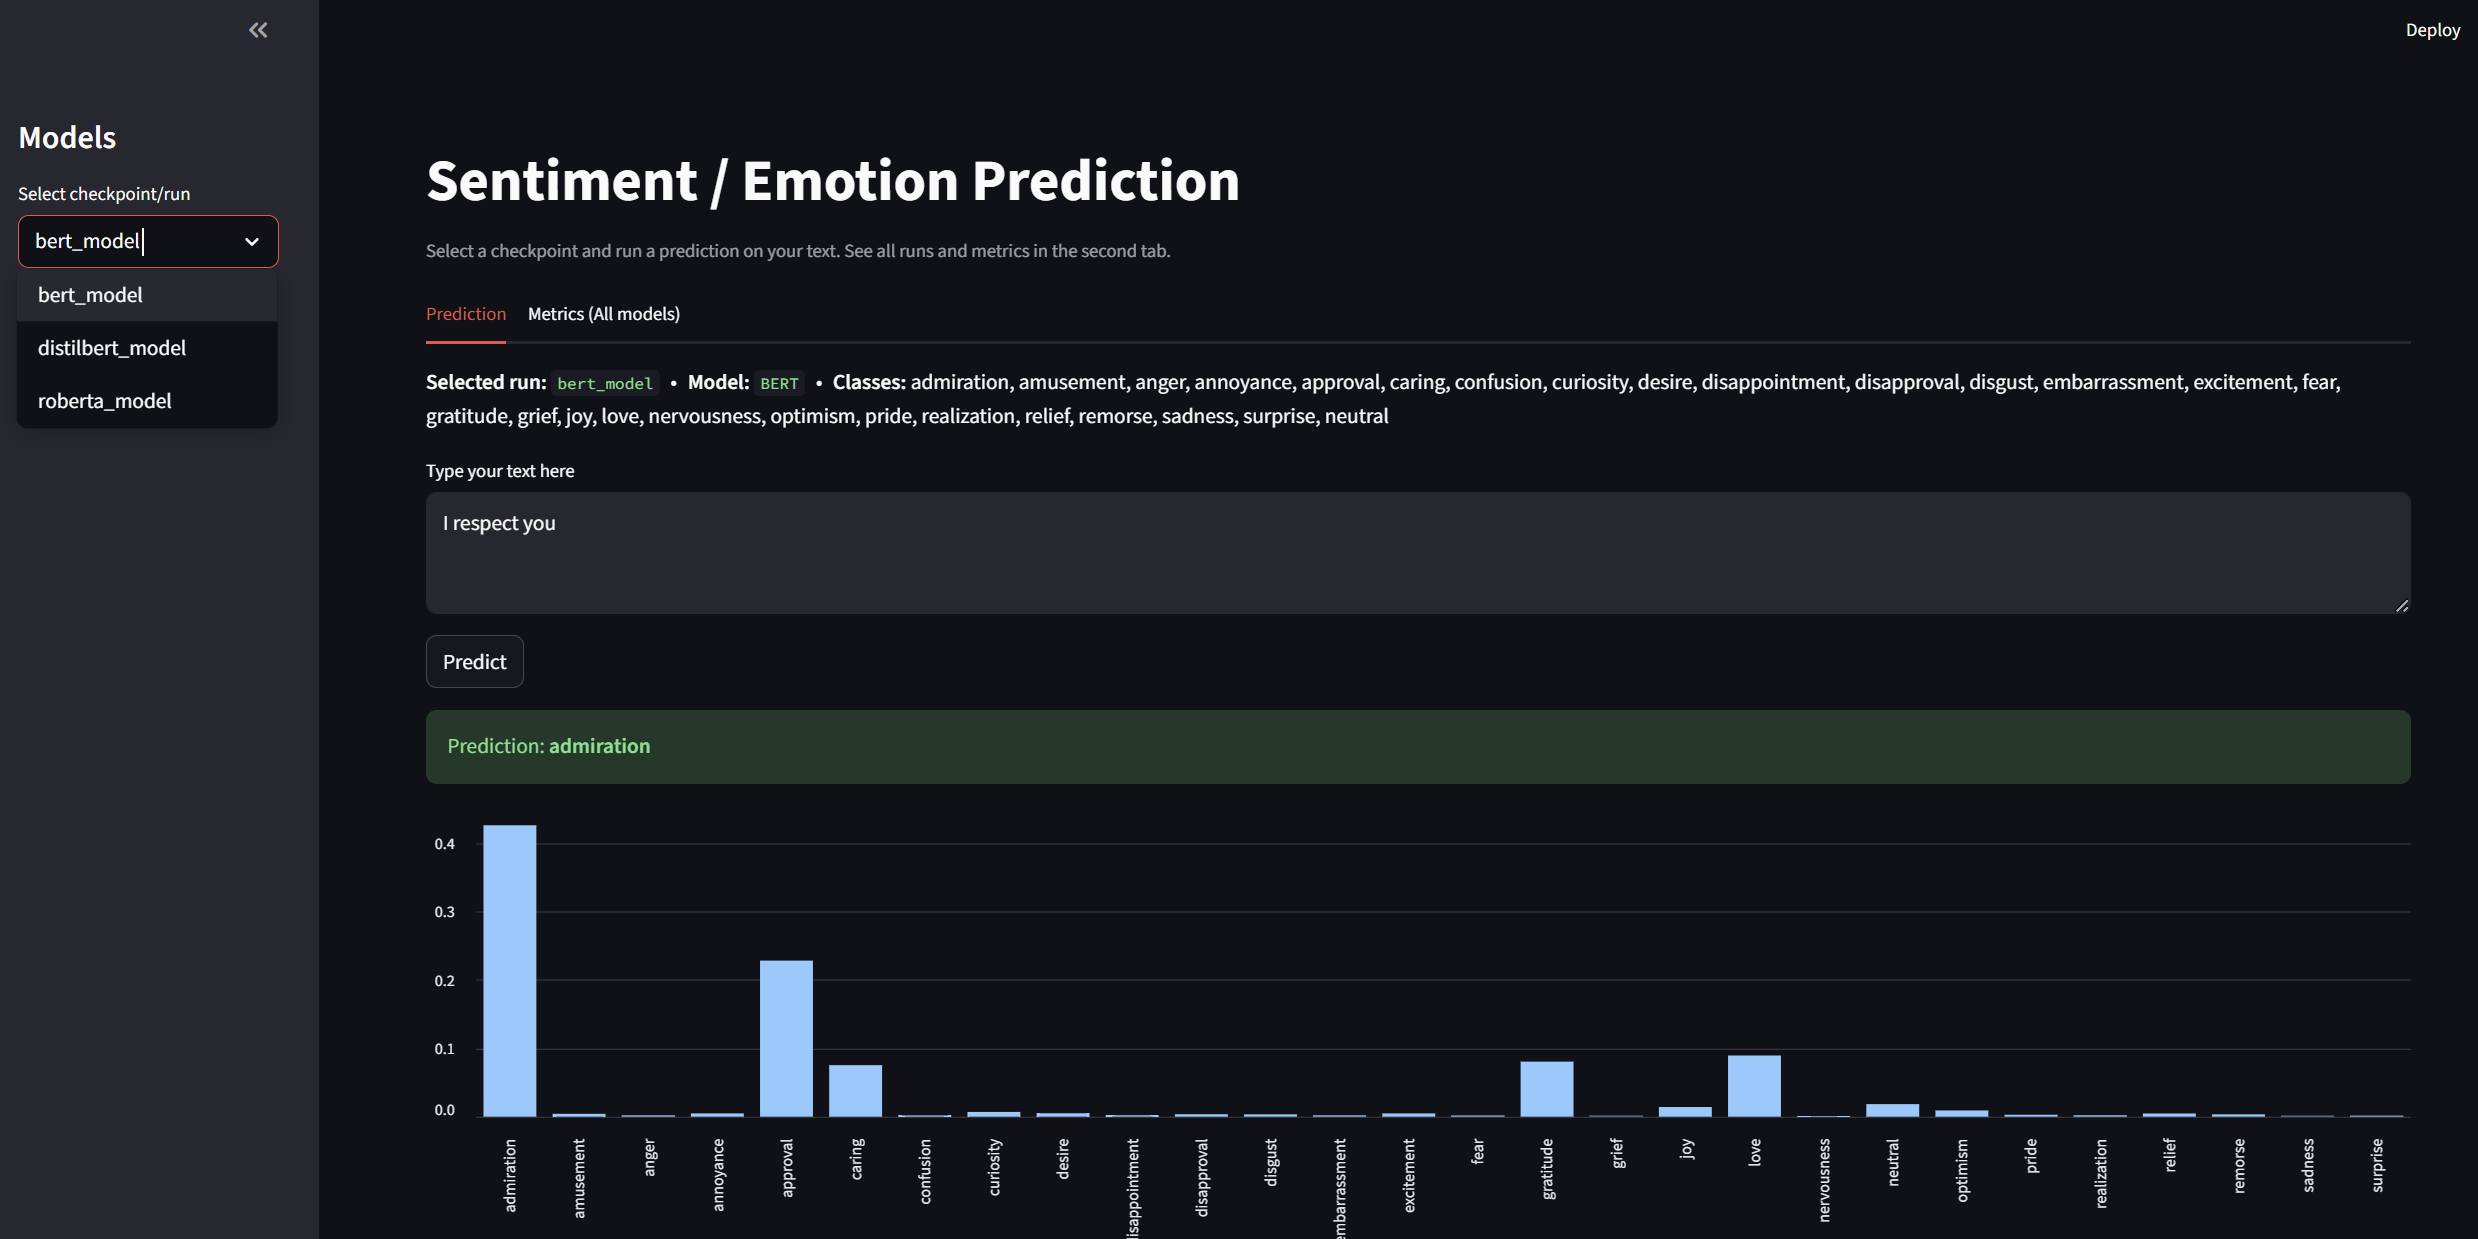
Figure 3

Metrics tab:

This tab takes from run_card.json, showing the tokenizer used and accuracy of each model in descending accuracy values. The graph below shows the training loss of the models.

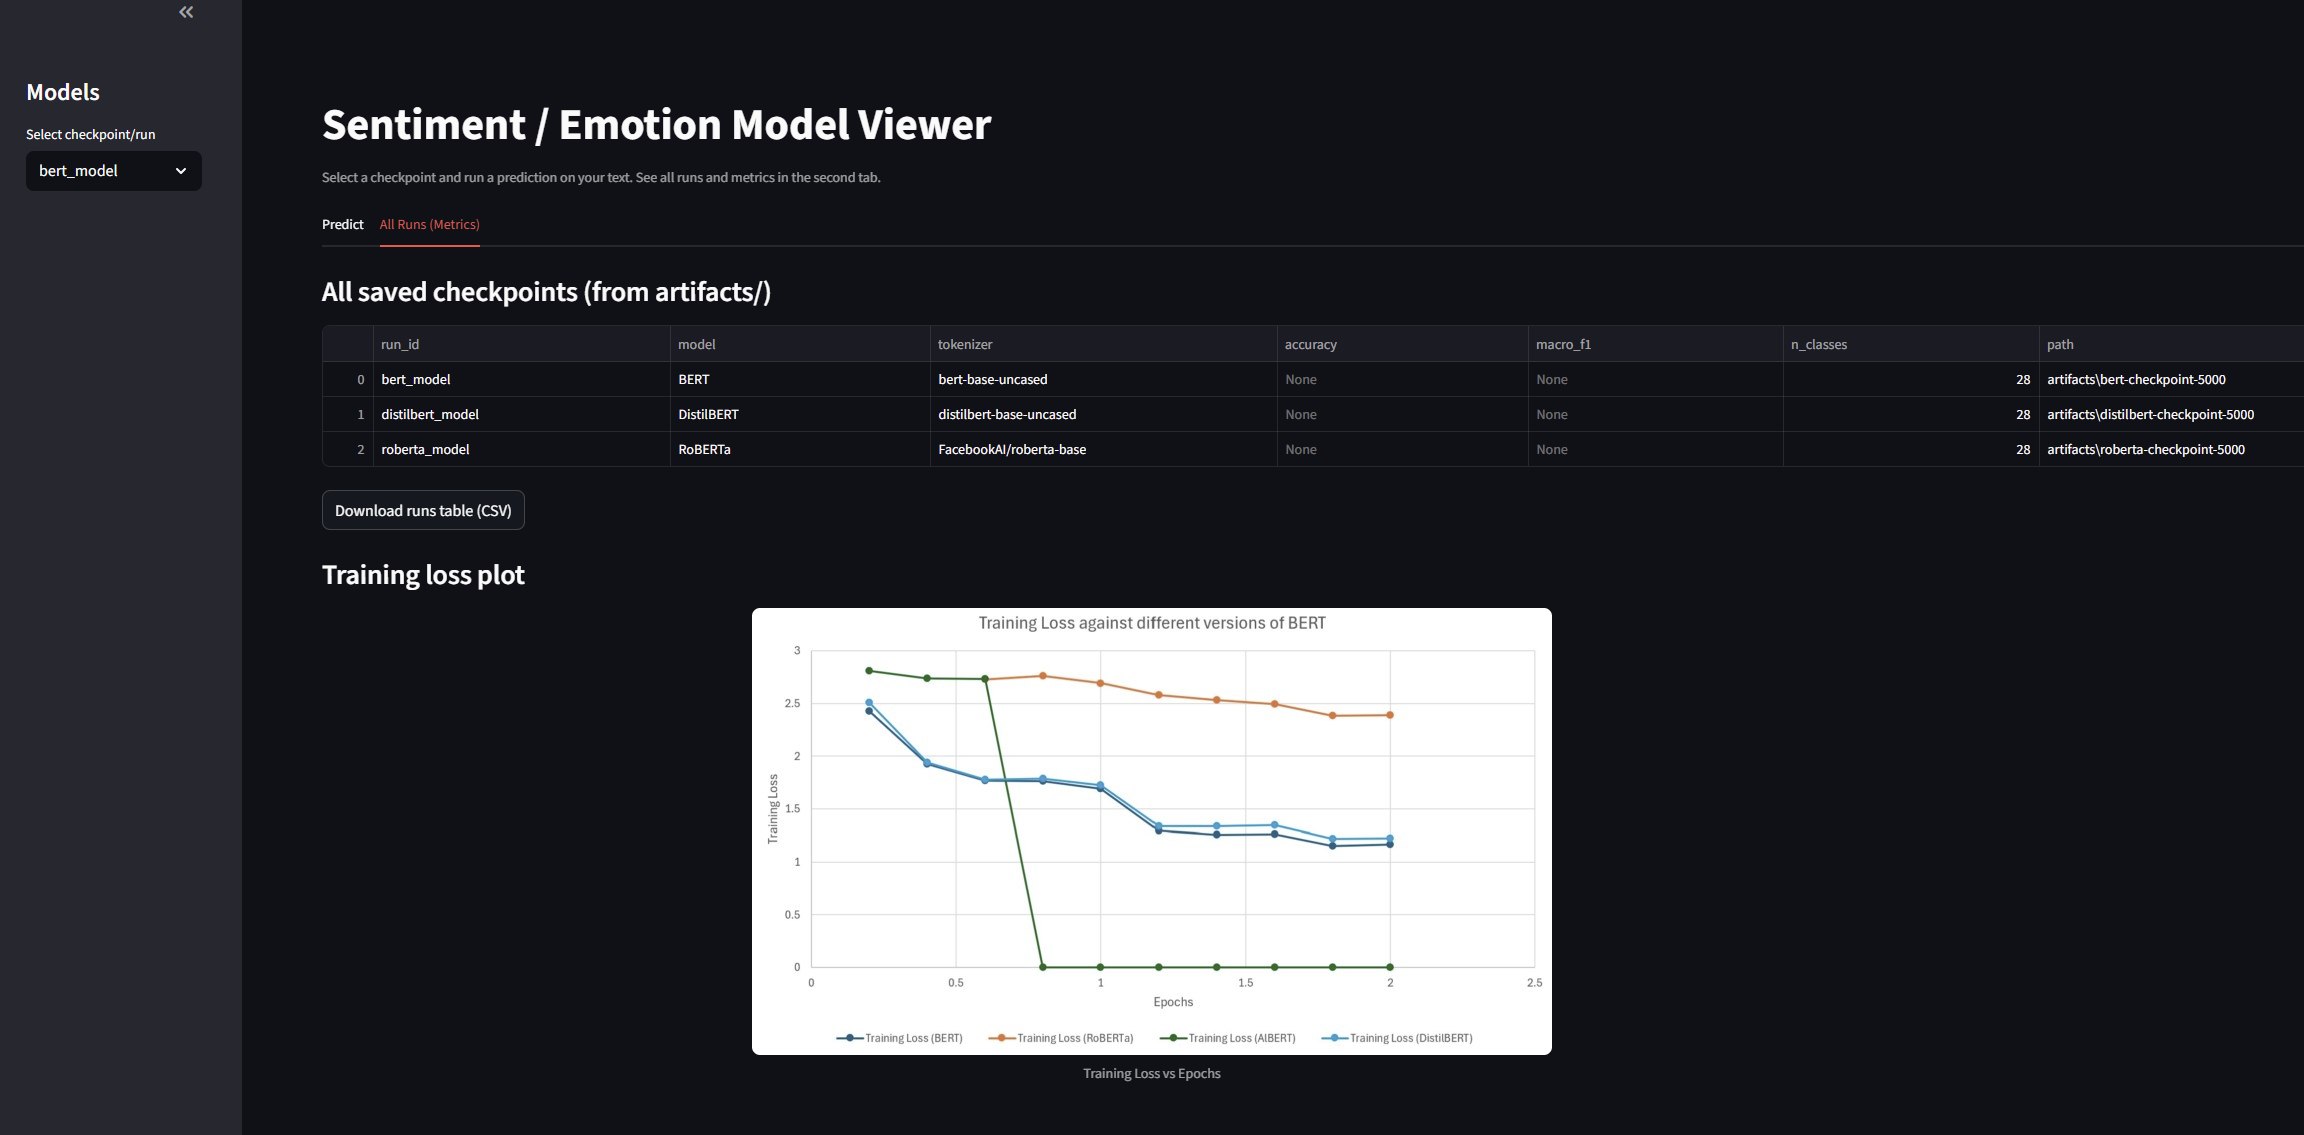
Figure 4

# References
* GoEmotions: A Dataset of Fine-Grained Emotions: https://arxiv.org/pdf/2005.00547
* fake-and-real-news-dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
* Sentiment Analysis for Mental Health: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
* Financial Sentiment Analysis: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
* Streamlit documentation: https://docs.streamlit.io/
* https://medium.com/@rajratangulab.more/fine-tuning-bert-for-text-classification-using-hugging-face-transformers-685c132d185d
* https://arxiv.org/pdf/1810.04805
* https://arxiv.org/pdf/1907.11692
* https://arxiv.org/pdf/1910.01108